In [14]:
import torch
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [15]:
# import os
# import pandas as pd
# from PIL import Image
# from torch.utils.data import Dataset
# import torch

# class RAFDBDataset(Dataset):
#     def __init__(self, csv_file, img_dir, transform=None):
#         self.labels = pd.read_csv(csv_file)
#         self.img_dir = img_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
#         image = Image.open(img_name)
#         label = self.labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)

#         return image, label

In [16]:
from rafdb_dataset import RAFDBDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

rafdb_dataset_train = RAFDBDataset(csv_file='archive/train_labels.csv',
                             img_dir='archive/DATASET/train',
                             transform=transform)

rafdb_dataset_test = RAFDBDataset(csv_file='archive/test_labels.csv',
                            img_dir='archive/DATASET/test',
                            transform=transform)

In [17]:
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=8, shuffle=True, num_workers=4)

data_test_loader = DataLoader(rafdb_dataset_test, batch_size=8, shuffle=False, num_workers=0)

In [18]:
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

Train batch: image shape torch.Size([64, 3, 64, 64]), labels shape torch.Size([64])


In [19]:
test_image, test_label = next(iter(data_test_loader))
print(f"Train batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([64, 3, 64, 64]), labels shape torch.Size([64])


In [20]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 6)

    def forward(self, x):
        x = F.relu(self.bn1(F.max_pool2d(self.conv1(x), 2)))
        x = F.relu(self.bn2(F.max_pool2d(self.conv2(x), 2)))
        x = F.relu(self.bn3(F.max_pool2d(self.conv3(x), 2)))
        x = self.pool(x)
        x = x.view(-1, 128)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [21]:
model = EmotionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(data_train_loader)}")


Epoch 1/15:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 1/15: 100%|██████████| 192/192 [00:28<00:00,  6.81it/s]


Epoch 1, Loss: 0.9001389552528659


Epoch 2/15: 100%|██████████| 192/192 [00:27<00:00,  6.91it/s]


Epoch 2, Loss: 0.8584095016121864


Epoch 3/15: 100%|██████████| 192/192 [00:27<00:00,  6.90it/s]


Epoch 3, Loss: 0.799888796483477


Epoch 4/15: 100%|██████████| 192/192 [00:27<00:00,  6.91it/s]


Epoch 4, Loss: 0.7002952607969443


Epoch 5/15: 100%|██████████| 192/192 [00:27<00:00,  6.93it/s]


Epoch 5, Loss: 0.6283209631219506


Epoch 6/15: 100%|██████████| 192/192 [00:27<00:00,  6.99it/s]


Epoch 6, Loss: 0.5767493885941803


Epoch 7/15: 100%|██████████| 192/192 [00:28<00:00,  6.82it/s]


Epoch 7, Loss: 0.5360550566886862


Epoch 8/15: 100%|██████████| 192/192 [00:27<00:00,  6.86it/s]


Epoch 8, Loss: 0.488879855023697


Epoch 9/15: 100%|██████████| 192/192 [00:27<00:00,  6.89it/s]


Epoch 9, Loss: 0.45955095005532104


Epoch 10/15: 100%|██████████| 192/192 [00:27<00:00,  6.92it/s]


Epoch 10, Loss: 0.4388039614229153


Epoch 11/15: 100%|██████████| 192/192 [00:28<00:00,  6.80it/s]


Epoch 11, Loss: 0.40600629267282784


Epoch 12/15: 100%|██████████| 192/192 [00:28<00:00,  6.85it/s]


Epoch 12, Loss: 0.3767246336210519


Epoch 13/15: 100%|██████████| 192/192 [00:27<00:00,  6.87it/s]


Epoch 13, Loss: 0.3560171684560676


Epoch 14/15: 100%|██████████| 192/192 [00:27<00:00,  6.94it/s]


Epoch 14, Loss: 0.3271734065686663


Epoch 15/15: 100%|██████████| 192/192 [00:27<00:00,  6.96it/s]

Epoch 15, Loss: 0.2954276866124322


In [22]:
def test_model(model, test_loader, device, criterion):
    model.eval()  
    test_loss = 0.0
    correct = 0
    total = 0
    losses = []
    accuracies = []

    with torch.no_grad(): 
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            losses.append(loss.item())
            accuracies.append(100.0 * (predicted == labels).sum().item() / labels.size(0))

    average_loss = test_loss / len(test_loader)
    average_accuracy = 100 * correct / total
    print(f'Average Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.2f}%')

    return losses, accuracies

Average Loss: 0.5075, Accuracy: 54.53%


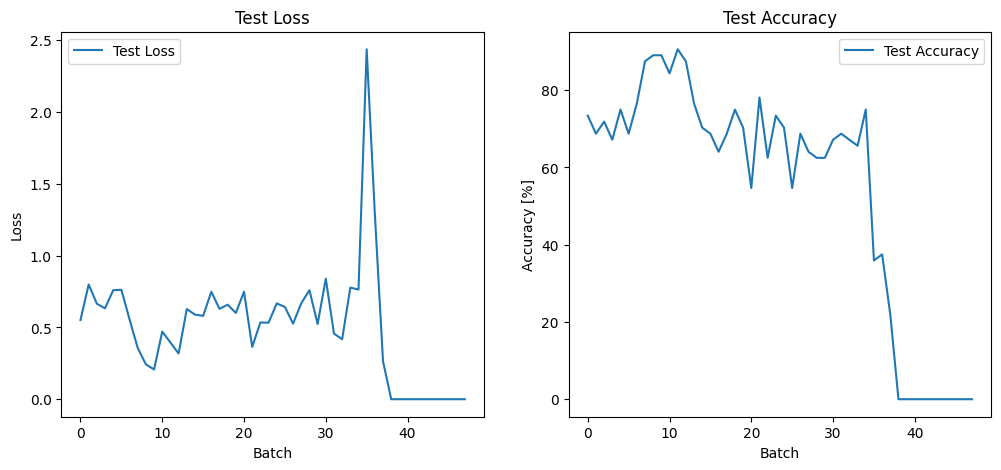

In [23]:
losses, accuracies = test_model(model, data_test_loader, device, criterion)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy [%]')
plt.legend()

plt.show()

In [24]:
class_labels = ['happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']
num_classes = len(class_labels)
num_images_per_class = 4

total_images = num_classes * num_images_per_class
class_images = {label: [] for label in range(num_classes)}

In [29]:
for images, labels in data_test_loader:
    for image, label in zip(images, labels):
        label = label.item()
        if label == num_classes:  # Adjust if there is an off-by-one error
            label -= 1  # Convert label from 1-indexed to 0-indexed if necessary
        if label not in class_images:
            print(f"Unexpected label {label}")
            continue
        if len(class_images[label]) < num_images_per_class:
            class_images[label].append(image)
        if all(len(class_images[i]) >= num_images_per_class for i in range(num_classes)):
            break
    if all(len(class_images[i]) >= num_images_per_class for i in range(num_classes)):
        break

Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected label 7
Unexpected l

IndexError: list index out of range

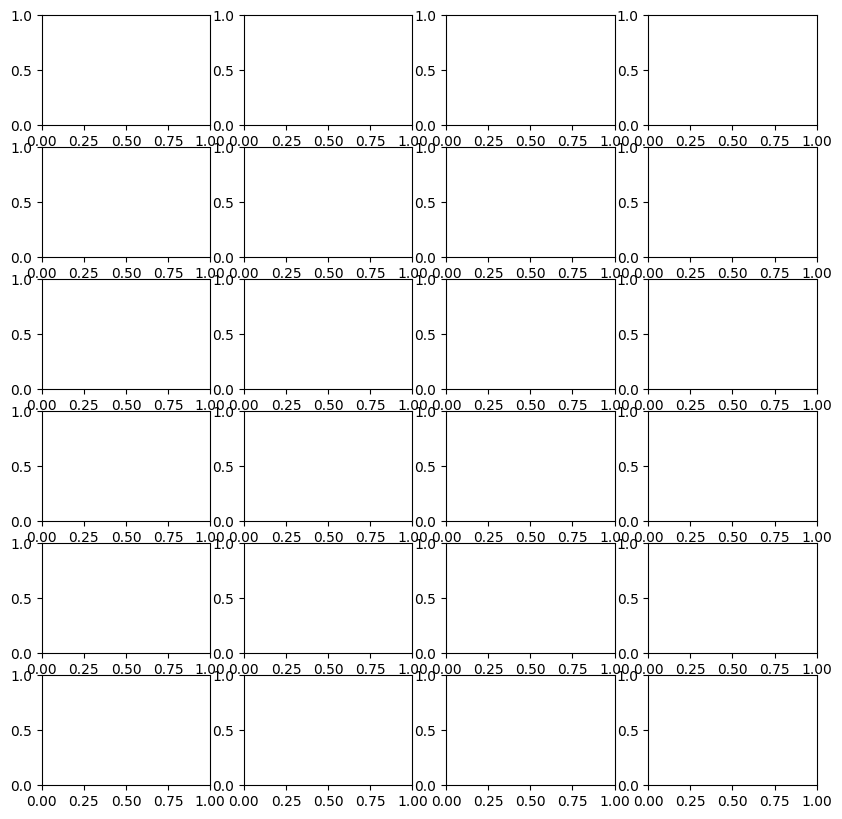

In [26]:
fig, axes = plt.subplots(nrows=num_classes, ncols=num_images_per_class, figsize=(10, 10))

for i, label in enumerate(class_labels):
    for j in range(num_images_per_class):
        ax = axes[i, j]
        ax.imshow(class_images[i][j].numpy().transpose((1, 2, 0))) 
        ax.set_title(label)
        ax.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


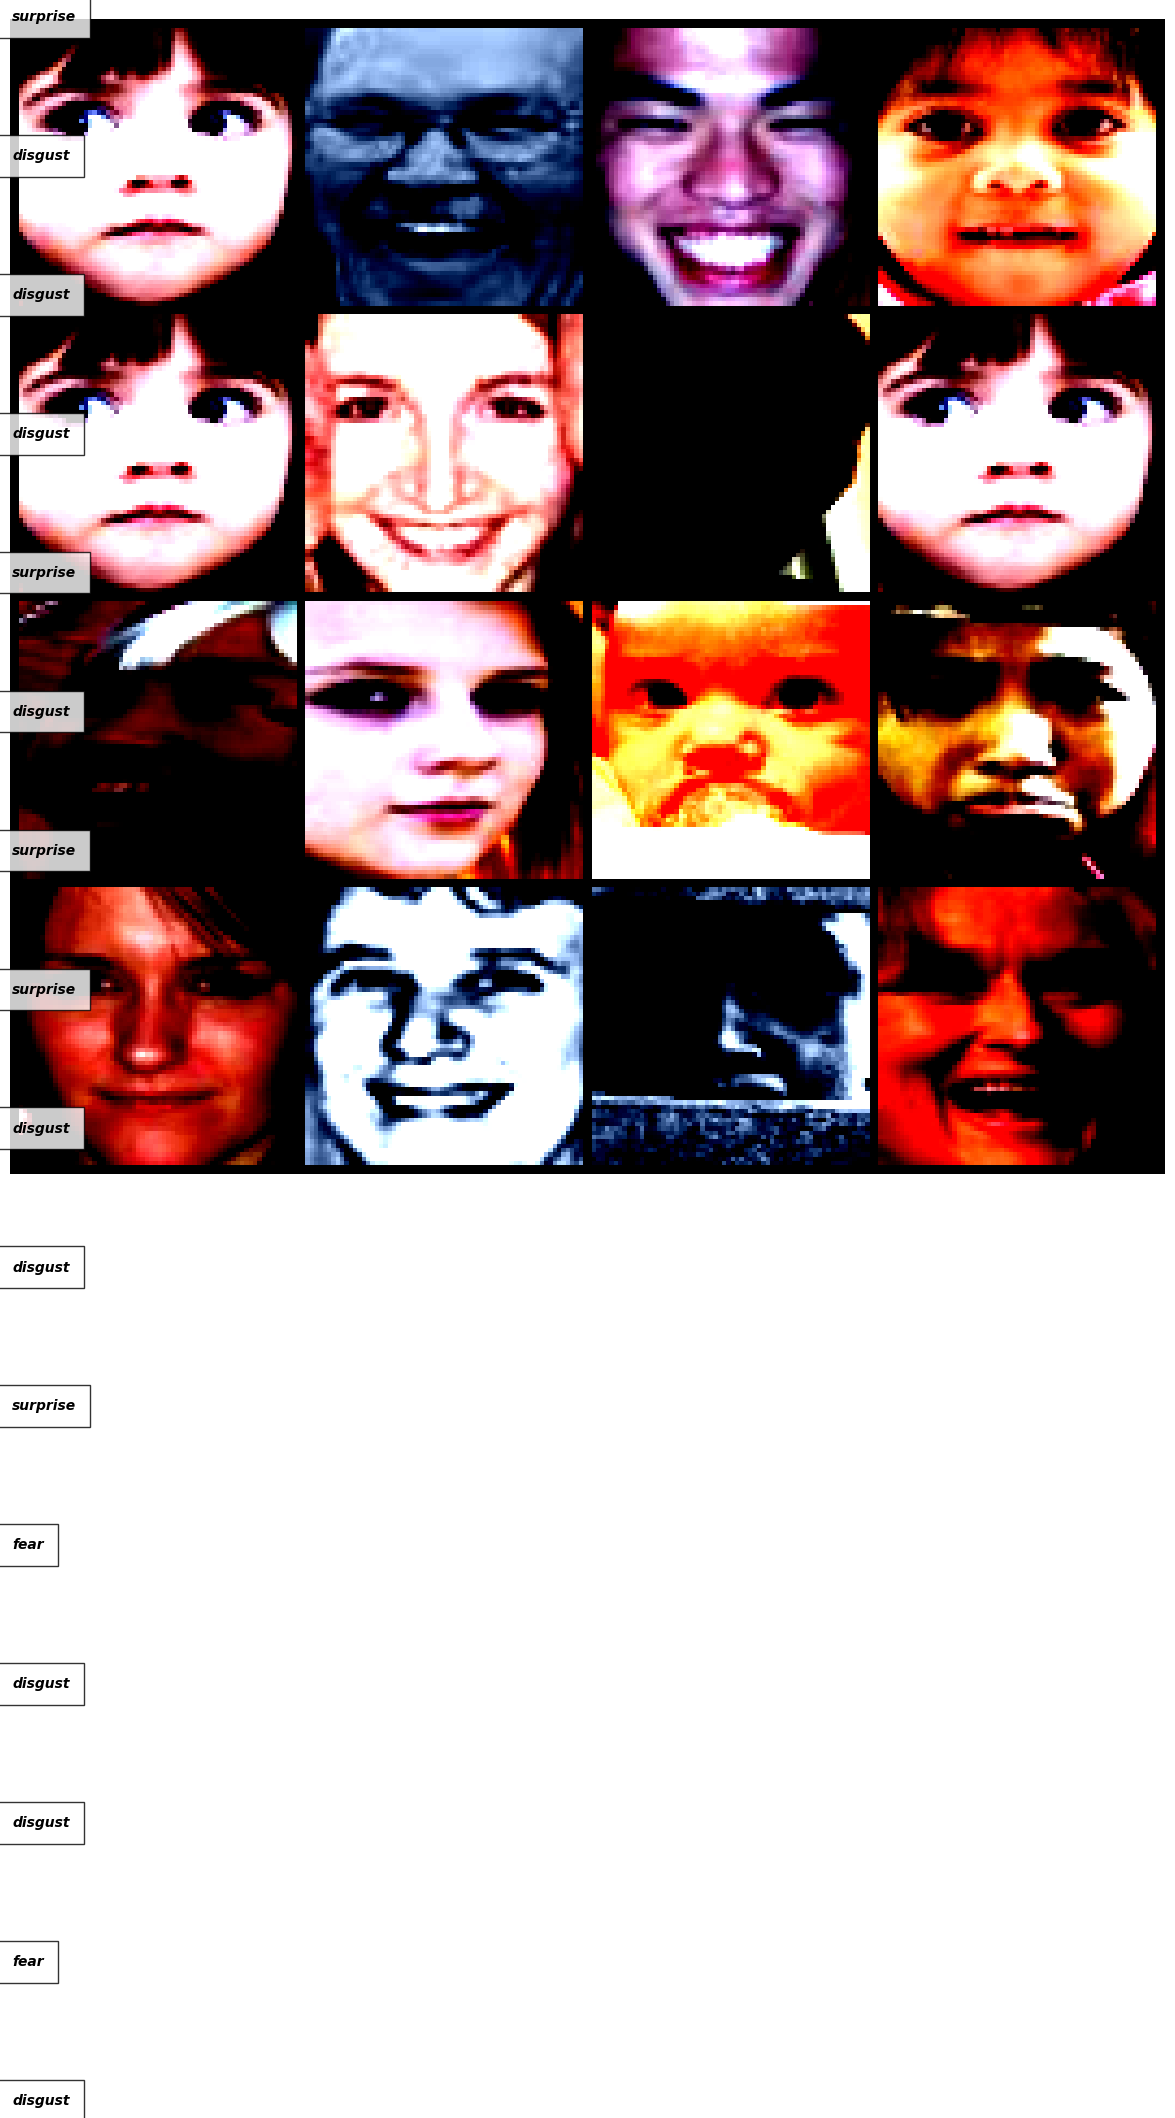

In [ ]:
# from torchvision.utils import make_grid

# test_image, test_label = next(iter(data_test_loader))
# idxs = torch.randint(0, test_image.shape[0], (16,))
# test_image, test_label = test_image[idxs], test_label[idxs]
# out = make_grid(test_image, nrow=4)
# plt.figure(figsize=(15, 15))
# plt.imshow(out.numpy().transpose((1, 2, 0)))
# plt.axis('off')
# for i in range(len(idxs)):
#     label = class_labels[test_label[i]]
#     plt.text(0, i * 32, label, style='italic', fontweight='bold', 
#              bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})

# plt.show()